In [1]:
# Cell 2: imports & load
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import pairwise_distances
sns.set_style("whitegrid")

# Try candidates
candidates = [
    "notebooks/features_with_rewards.csv",
    "notebooks/features_agg.csv",
    "notebooks/features.csv",
    "features_with_rewards.csv",
    "features_agg.csv",
    "features.csv"
]
df = None
for p in candidates:
    if os.path.exists(p):
        df = pd.read_csv(p)
        print("Loaded:", p)
        break

if df is None:
    raise FileNotFoundError("No features CSV found. Put features_agg.csv or features_with_rewards.csv in notebooks/")

print("Raw shape:", df.shape)
df.head()


Loaded: features_agg.csv
Raw shape: (1015, 9)


,session_id,src_ip,start,end,duration,cmd_count,unique_cmds,downloads,reward
0,68f4d3a2fd47e0aa10c84117,1.2.3.4,NaN,NaN,0,0,0,0,0.0
1,68f4dcdd1f21559d39a3732f,1.2.3.4,NaN,NaN,0,0,0,0,0.0
2,68f607bbb10cf72b09c6787d,1.2.3.4,NaN,NaN,0,0,0,0,0.0
3,68f720ab2c0f081e0b60fb58,1.2.3.4,NaN,NaN,0,0,0,0,0.0
4,68f8c5e2f6603c4190887d16,1.2.3.4,NaN,NaN,0,0,0,0,0.0


In [2]:
# Cell 3: select numeric features and preprocess
# Remove non-numeric columns commonly present
drop_cols = [c for c in df.columns if c.lower() in ("session_id","session","start","end","src_ip")]
# Also drop object/text columns (events etc.)
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
# Keep reward if present; drop long text fields
drop_cols += [c for c in obj_cols if c not in ('reward',)]

print("Dropping columns:", drop_cols[:20])
X = df.drop(columns=drop_cols, errors='ignore').copy()

# Keep only numeric columns (in case)
X = X.select_dtypes(include=[np.number]).copy()
print("Feature columns used:", X.columns.tolist())

# Fill missing and scale
X = X.fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)


Dropping columns: ['session_id', 'src_ip', 'start', 'end', 'session_id', 'src_ip']
Feature columns used: ['duration', 'cmd_count', 'unique_cmds', 'downloads', 'reward']
X_scaled shape: (1015, 5)


PCA 2D explained variance: 1.000


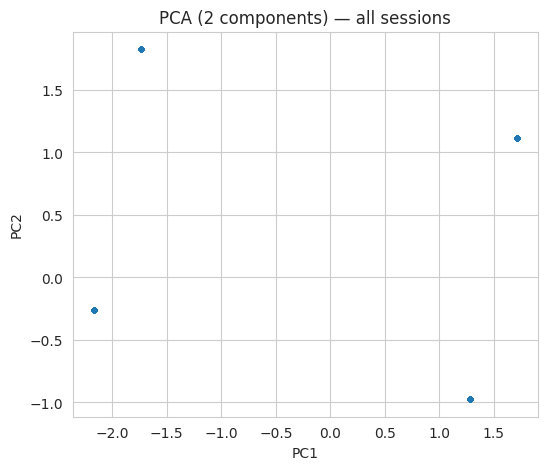

In [3]:
# Cell 4: PCA 2-component for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.sum()
print(f"PCA 2D explained variance: {explained:.3f}")

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], s=8, alpha=0.7)
plt.title("PCA (2 components) — all sessions")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


/home/hussainaaa/Desktop/project_honeypot/venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/hussainaaa/Desktop/project_honeypot/venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/hussainaaa/Desktop/project_honeypot/venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/home/hussainaaa/Desktop/project_honeypot/venv/lib/python3.12/site-packages/sklearn/base.py:1365: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8).

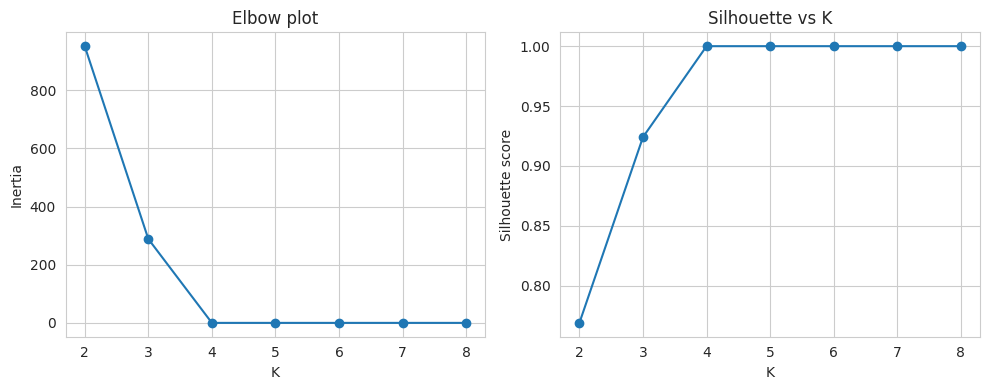

Inertia: [952.0640685513092, 288.69896502919005, 2.0800709000770927e-26, 2.2527328307073417e-26, 2.2527328307073417e-26, 2.244770265945267e-26, 2.4354527378791586e-26]
Silhouette scores: [0.7687829436315862, 0.9240419075786749, 1.0, 1.0, 1.0, 1.0, 1.0]


In [4]:
# Cell 5: KMeans elbow plot + silhouette for a handful of K
from sklearn.metrics import silhouette_score
Ks = list(range(2,9))
inertia = []
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels) if len(set(labels))>1 else np.nan
    sil_scores.append(sil)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertia, "-o")
plt.xlabel("K"); plt.ylabel("Inertia"); plt.title("Elbow plot")

plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, "-o")
plt.xlabel("K"); plt.ylabel("Silhouette score"); plt.title("Silhouette vs K")
plt.tight_layout()
plt.show()

print("Inertia:", inertia)
print("Silhouette scores:", sil_scores)


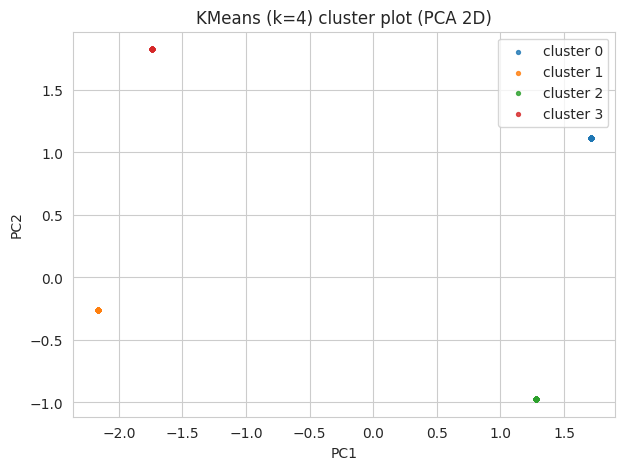

Cluster sizes (KMeans):
0    253
1    340
2    344
3     78
Name: count, dtype: int64


In [5]:
# Cell 6: fit KMeans with selected K
n_clusters = 4   # << change this based on elbow/silhouette
km = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
km_labels = km.fit_predict(X_scaled)
df['kmeans_label'] = km_labels

# PCA scatter colored by kmeans label
plt.figure(figsize=(7,5))
palette = sns.color_palette("tab10", n_clusters)
for lab in sorted(set(km_labels)):
    idx = km_labels == lab
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=8, alpha=0.8, label=f"cluster {lab}")
plt.legend()
plt.title(f"KMeans (k={n_clusters}) cluster plot (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Cluster sizes (KMeans):")
print(pd.Series(km_labels).value_counts().sort_index())


In [6]:
# Cell 7: describe clusters (mean feature values)
cluster_stats = df.groupby('kmeans_label')[X.columns.tolist()].mean().T
display(cluster_stats.iloc[:20,:])  # show top 20 features by row

# Alternatively show top features per cluster (sorted descending)
for lab in sorted(df['kmeans_label'].unique()):
    print(f"\nTop features (cluster {lab}):")
    means = df[df['kmeans_label']==lab][X.columns].mean().sort_values(ascending=False).head(8)
    print(means)


kmeans_label,0,1,2,3
duration,0.0,0.0,0.0,0.0
cmd_count,5.0,0.0,5.0,0.0
unique_cmds,1.0,0.0,1.0,0.0
downloads,5.0,0.0,0.0,5.0
reward,0.4,0.0,0.4,0.0



Top features (cluster 0):
cmd_count      5.0
downloads      5.0
unique_cmds    1.0
reward         0.4
duration       0.0
dtype: float64

Top features (cluster 1):
duration       0.0
cmd_count      0.0
unique_cmds    0.0
downloads      0.0
reward         0.0
dtype: float64

Top features (cluster 2):
cmd_count      5.0
unique_cmds    1.0
reward         0.4
duration       0.0
downloads      0.0
dtype: float64

Top features (cluster 3):
downloads      5.0
duration       0.0
cmd_count      0.0
unique_cmds    0.0
reward         0.0
dtype: float64


DBSCAN clusters found (excluding noise -1): 4
DBSCAN silhouette (if computed): 1.0


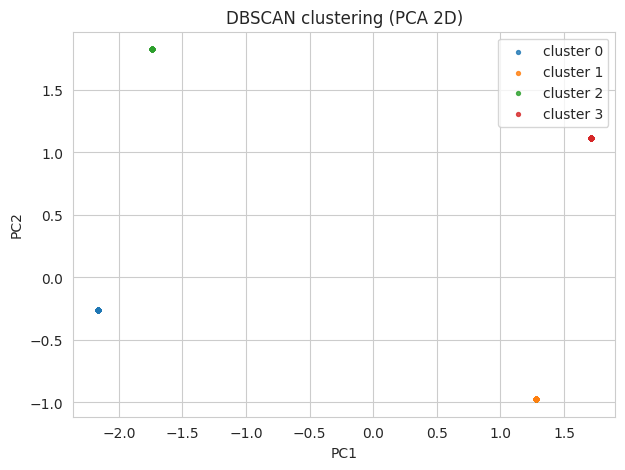

In [7]:
# Cell 8: DBSCAN
db = DBSCAN(eps=0.6, min_samples=5, metric='euclidean', n_jobs=-1)  # adjust eps
db_labels = db.fit_predict(X_scaled)
df['dbscan_label'] = db_labels

n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
print("DBSCAN clusters found (excluding noise -1):", n_clusters_db)
if n_clusters_db > 0:
    try:
        sil_db = silhouette_score(X_scaled, db_labels)
    except Exception:
        sil_db = None
    print("DBSCAN silhouette (if computed):", sil_db)
else:
    print("DBSCAN created only noise or single cluster; try adjusting eps/min_samples")

# PCA plot for DBSCAN
plt.figure(figsize=(7,5))
unique_labels = sorted(set(db_labels))
colors = sns.color_palette("husl", max(2, len(unique_labels)))
for lab in unique_labels:
    idx = db_labels == lab
    label_name = f"noise" if lab == -1 else f"cluster {lab}"
    plt.scatter(X_pca[idx,0], X_pca[idx,1], s=8, alpha=0.8, label=label_name)
plt.legend()
plt.title("DBSCAN clustering (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


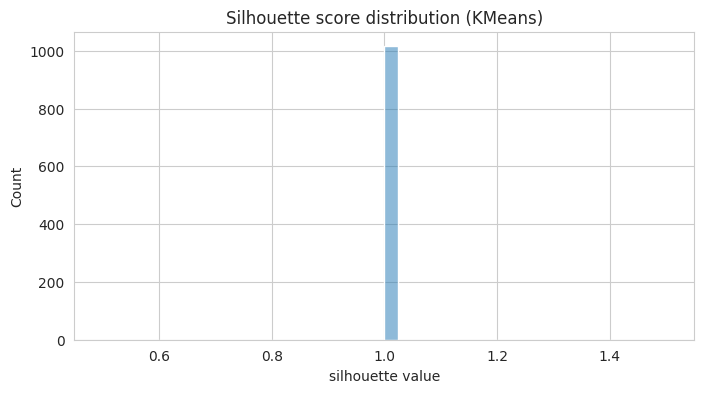

Mean silhouette (KMeans): 1.0


In [8]:
# Cell 9: silhouette per sample (KMeans)
if len(set(km_labels)) > 1:
    sil_vals = silhouette_samples(X_scaled, km_labels)
    df['kmeans_silhouette'] = sil_vals
    plt.figure(figsize=(8,4))
    sns.histplot(sil_vals, bins=40, kde=True)
    plt.title("Silhouette score distribution (KMeans)")
    plt.xlabel("silhouette value")
    plt.show()
    print("Mean silhouette (KMeans):", sil_vals.mean())
else:
    print("Not enough clusters for silhouette samples")


In [9]:
# Cell 10: save labeled dataframe
out_path = "notebooks/features_clusters.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
df_out = df.copy()
# keep relevant columns + labels
keep_cols = ['session_id','src_ip','start','end','duration','cmd_count','unique_cmds','downloads','reward']
keep_cols = [c for c in keep_cols if c in df_out.columns]
save_cols = keep_cols + ['kmeans_label','dbscan_label']
# include all numeric features optionally — if needed
df_out.to_csv(out_path, index=False)
print("Saved clustered dataframe to", out_path)
df_out.head()


Saved clustered dataframe to notebooks/features_clusters.csv


,session_id,src_ip,start,end,duration,cmd_count,unique_cmds,downloads,reward,kmeans_label,dbscan_label,kmeans_silhouette
0,68f4d3a2fd47e0aa10c84117,1.2.3.4,NaN,NaN,0,0,0,0,0.0,1,0,1.0
1,68f4dcdd1f21559d39a3732f,1.2.3.4,NaN,NaN,0,0,0,0,0.0,1,0,1.0
2,68f607bbb10cf72b09c6787d,1.2.3.4,NaN,NaN,0,0,0,0,0.0,1,0,1.0
3,68f720ab2c0f081e0b60fb58,1.2.3.4,NaN,NaN,0,0,0,0,0.0,1,0,1.0
4,68f8c5e2f6603c4190887d16,1.2.3.4,NaN,NaN,0,0,0,0,0.0,1,0,1.0
